In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.image import resize as tf_resize

In [2]:
print("Loading CIFAR-10 dataset...")
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

     

Loading CIFAR-10 dataset...


In [3]:
train_images, test_images = train_images / 255.0, test_images / 255.0

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Number of classes: {len(class_names)}")


Train images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)
Number of classes: 10


In [6]:
class SelfAttention(layers.Layer):
    def __init__(self, channels, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = channels
        # Using activation='relu' might be unusual for key/query/value transforms
        # Typically linear transformations are used before the dot product.
        # Let's stick to the original code's structure for now, but note this
        # could be a point for future optimization/experimentation.
        self.query_conv = layers.Conv2D(channels // 8, kernel_size=1, activation='relu', use_bias=False)
        self.key_conv = layers.Conv2D(channels // 8, kernel_size=1, activation='relu', use_bias=False)
        self.value_conv = layers.Conv2D(channels, kernel_size=1, activation='relu', use_bias=False)
        self.gamma = tf.Variable(0.0, trainable=True, name='gamma')

    def call(self, inputs):
        # Get shape using tf.shape() which returns a tensor
        shape = tf.shape(inputs)
        batch_size = shape[0]
        h = shape[1]
        w = shape[2]
        c = shape[3]

        query = self.query_conv(inputs)
        key = self.key_conv(inputs)
        value = self.value_conv(inputs)

        # Reshape using the tensor-based shape info
        query_flat = tf.reshape(query, [batch_size, h * w, -1])
        key_flat = tf.reshape(key, [batch_size, h * w, -1])
        value_flat = tf.reshape(value, [batch_size, h * w, -1])

        # Calculate attention scores
        # (batch_size, N, N)
        attention_scores = tf.matmul(query_flat, key_flat, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)

        # Apply attention scores to values
        # (batch_size, N, C)
        out = tf.matmul(attention_scores, value_flat)
        out = tf.reshape(out, [batch_size, h, w, c])

        out = self.gamma * out + inputs
        return out, attention_scores

    # Implement compute_output_shape to explicitly define output shapes
    def compute_output_shape(self, input_shape):
        # input_shape is typically (batch_size, H, W, C)
        # The output 'out' has the same shape as the input
        output_shape_out = input_shape

        # The attention scores shape is (batch_size, H*W, H*W)
        _, h, w, _ = input_shape
        n = h * w
        output_shape_scores = (input_shape[0], n, n)

        return [output_shape_out, output_shape_scores]

In [7]:
def build_attention_cnn_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Feature extraction with CNN layers
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    # The output of this MaxPooling will be the input to the attention layer
    pre_attention_features = layers.MaxPooling2D((2, 2), name='pre_attention_pool')(x)
    x = layers.Dropout(0.25)(pre_attention_features)

    # Add the Self-Attention Layer
    # We use a custom layer for self-attention, which now returns two outputs
    attention_output, attention_scores = SelfAttention(channels=128, name='self_attention_layer')(x)

    # Apply activation after the residual connection in the attention layer
    # or here, depending on design. Let's keep it consistent with the original code's placement
    # but note that activation inside the SelfAttention layer after the residual
    # might be more typical. The original code applies it *after* the SelfAttention call.
    post_attention_features = layers.Activation('relu', name='post_attention_activation')(attention_output)


    # Classification head
    x = layers.Flatten()(post_attention_features)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Return a Keras Model for functional API
    return Model(inputs=inputs, outputs=outputs, name='attention_cnn_model'), attention_scores, pre_attention_features, post_attention_features
     

In [8]:
input_shape = train_images.shape[1:]
num_classes = len(class_names)

In [9]:

model, attention_scores_tensor, pre_attention_features_tensor, post_attention_features_tensor = build_attention_cnn_model(input_shape, num_classes)
# Display model summary
model.summary()

Model: "attention_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pre_attention_pool              │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_layer            │ [(None, 4, 4, 128),    │        20,480 │
│ (SelfAttention)                 │ (None, 16, 16)]        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ post_attention_activation       │ (None, 4, 4, 128)      │             

 Total params: 1,363,498 (5.20 MB)

 Trainable params: 1,362,602 (5.20 MB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
print("\nCompiling model...")
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

EPOCHS = 20
BATCH_SIZE = 64

print(f"Training model for {EPOCHS} epochs with batch size {BATCH_SIZE}...")
history = model.fit(train_images, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(test_images, test_labels))



Compiling model...
Training model for 20 epochs with batch size 64...
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 185s 229ms/step - accuracy: 0.3364 - loss: 2.0348 - val_accuracy: 0.5228 - val_loss: 1.3095
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 179s 229ms/step - accuracy: 0.5640 - loss: 1.2178 - val_accuracy: 0.6643 - val_loss: 0.9354
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 164s 209ms/step - accuracy: 0.6590 - loss: 0.9779 - val_accuracy: 0.6600 - val_loss: 1.0016
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 160s 204ms/step - accuracy: 0.7006 - loss: 0.8654 - val_accuracy: 0.7396 - val_loss: 0.7730
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 172s 220ms/step - accuracy: 0.7279 - loss: 0.7913 - val_accuracy: 0.7694 - val_loss: 0.6672
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 171s 219ms/step - accuracy: 0.7548 - loss: 0.7136 - val_accuracy: 0.7249 - val_loss: 0.8299
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 188s 240ms/step - accuracy: 0.7770 - loss: 0.6638 - val_accuracy: 0.7779 - val_loss: 0.6540
Epoch

In [11]:
print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest accuracy: {test_acc}")


Evaluating model...
313/313 - 6s - 20ms/step - accuracy: 0.8483 - loss: 0.4973

Test accuracy: 0.8482999801635742


<Figure size 1400x600 with 0 Axes>

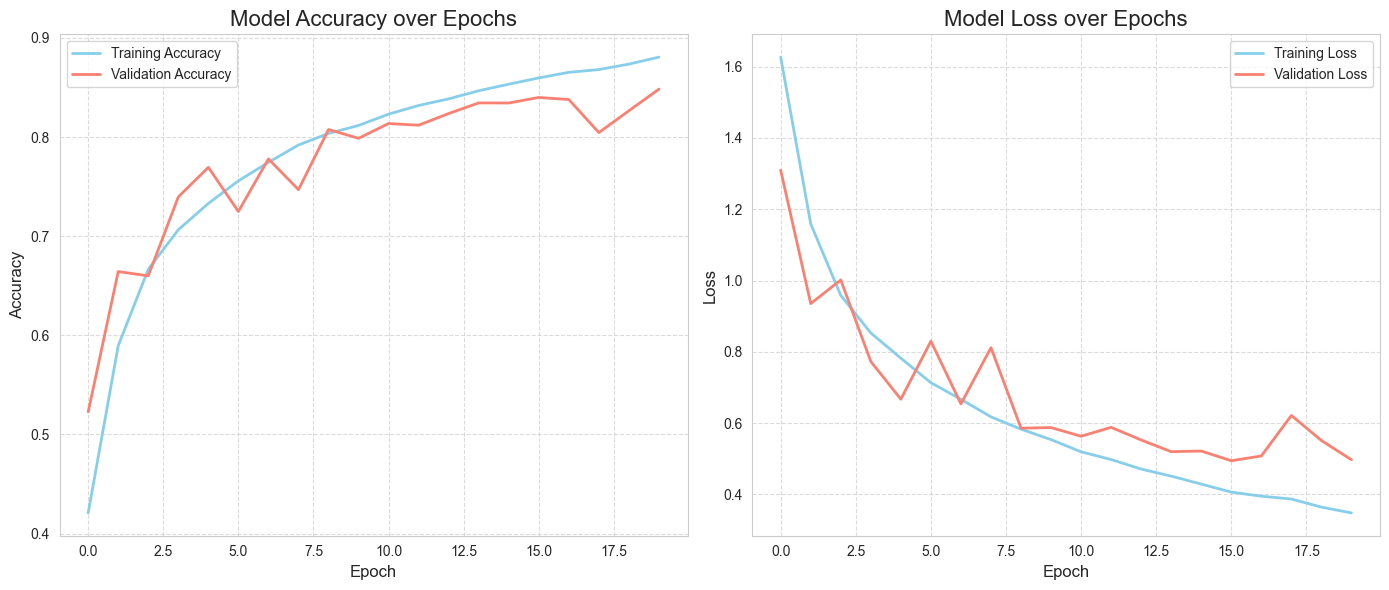

In [12]:
# Set a style for plots
sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))

# Plot Training and Validation Accuracy
sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='skyblue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='salmon', linewidth=2)
plt.title('Model Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='skyblue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='salmon', linewidth=2)
plt.title('Model Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Visualizing some predictions with attention heatmaps...
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step


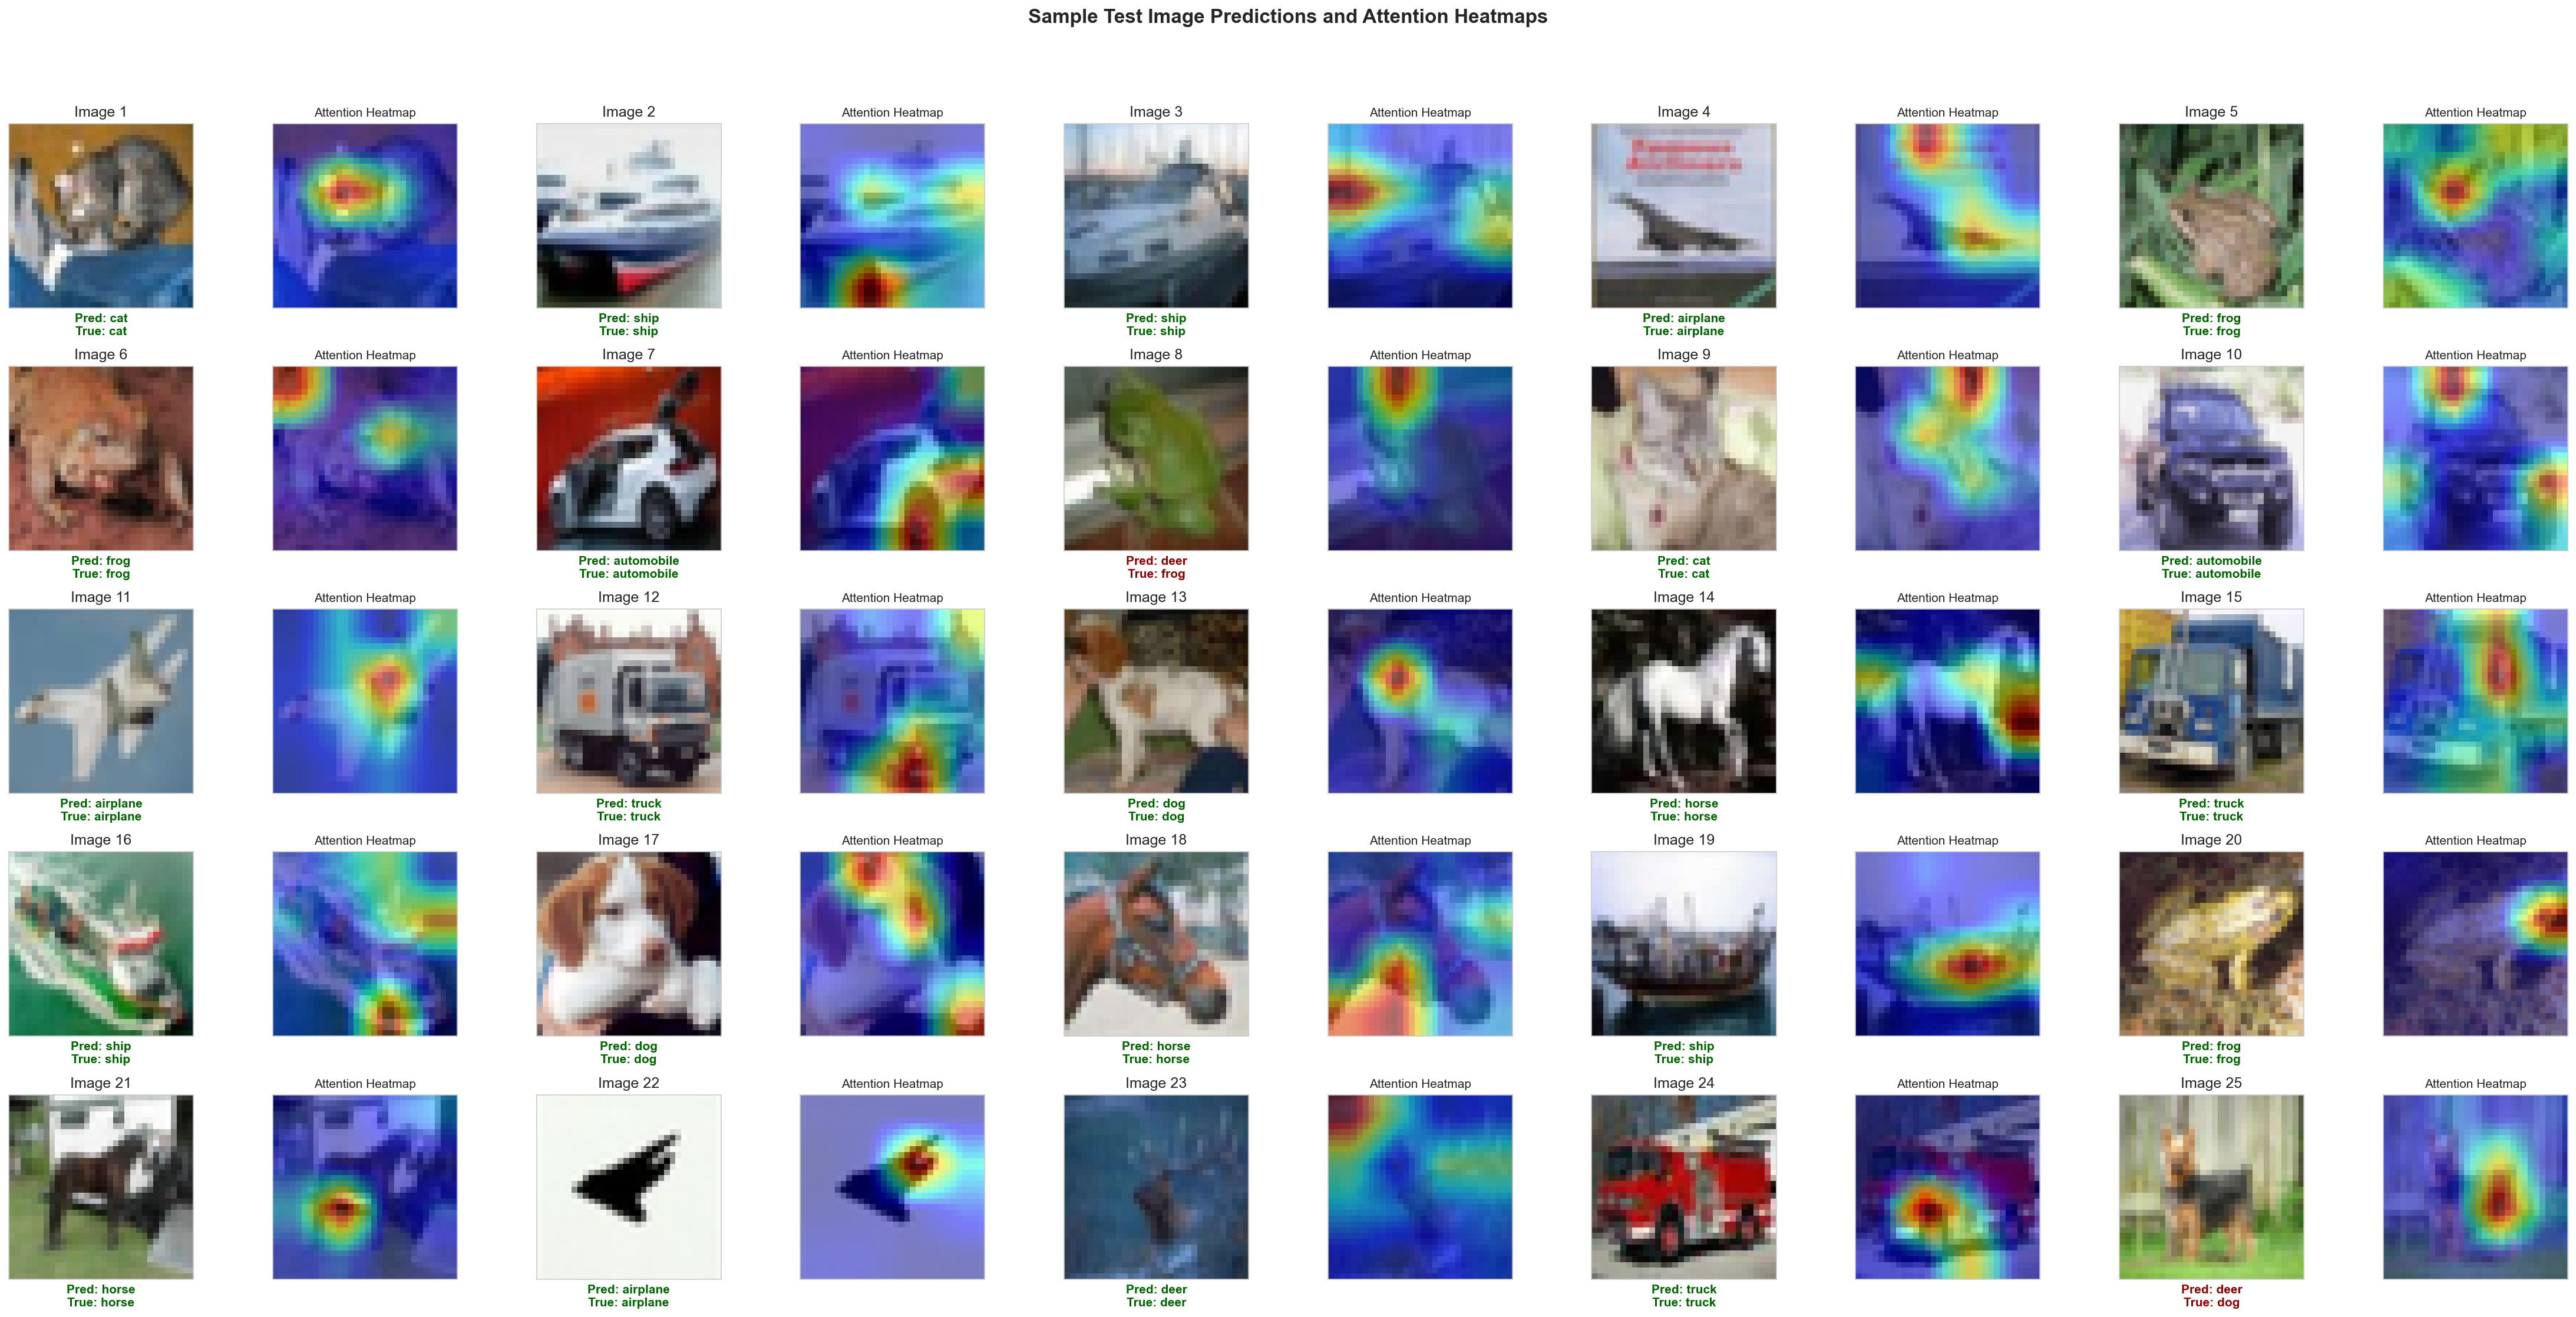

In [13]:
print("\nVisualizing some predictions with attention heatmaps...")

# Create a functional model to get outputs at specific layers
# This model will output the final predictions AND the attention map
attention_model_with_preds = Model(inputs=model.input,
                                   outputs=[model.output,  # Final predictions
                                            post_attention_features_tensor, # Features after attention for spatial dim reference
                                            attention_scores_tensor]) # Raw attention scores

# Get predictions and attention data for all test images
predictions, post_attention_features_all, attention_scores_all = \
    attention_model_with_preds.predict(test_images)

num_images_to_display = 25 # Display 25 images
images_per_row = 5
images_per_column = num_images_to_display // images_per_row

# Calculate figure size based on the number of images and desired subplot size
# Each pair of image + heatmap will take up 2 columns
# Each row will have 'images_per_row' pairs
# Figure width = (images_per_row * 2 columns per pair) * subplot width
# Figure height = images_per_column * subplot height
subplot_width = 3  # Adjust as needed
subplot_height = 3 # Adjust as needed
plt.figure(figsize=(images_per_row * 2 * subplot_width, images_per_column * subplot_height), dpi=150)

for i in range(num_images_to_display):
    # Determine the subplot position (row, column)
    row = i // images_per_row
    col = i % images_per_row

    # Original Image Plot
    plt.subplot(images_per_column, images_per_row * 2, row * (images_per_row * 2) + col * 2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])

    predicted_label_index = np.argmax(predictions[i])
    true_label_index = test_labels[i][0]

    predicted_label_name = class_names[predicted_label_index]
    true_label_name = class_names[true_label_index]

    if predicted_label_index == true_label_index:
        color = 'darkgreen'  # More distinct green for correct
    else:
        color = 'darkred'  # More distinct red for incorrect

    plt.xlabel(f"Pred: {predicted_label_name}\nTrue: {true_label_name}", color=color, fontsize=10,
               fontweight='bold')  # Bold labels
    plt.title(f"Image {i + 1}")


    # Attention Heatmap Plot
    plt.subplot(images_per_column, images_per_row * 2, row * (images_per_row * 2) + col * 2 + 2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Process Attention Scores for Heatmap for this image
    attention_scores_val = attention_scores_all[i]
    attention_map_flat = np.mean(attention_scores_val, axis=0)

    h_prime, w_prime, _ = post_attention_features_all.shape[1:]
    attention_map_2d = attention_map_flat.reshape(h_prime, w_prime)
    attention_map_2d = (attention_map_2d - attention_map_2d.min()) / (attention_map_2d.max() - attention_map_2d.min() + 1e-8)

    # Display the original image and overlay the attention heatmap
    plt.imshow(test_images[i])
    resized_attention_map = tf.image.resize(tf.expand_dims(attention_map_2d, -1),
                                            test_images[i].shape[:2],
                                            method='bilinear')[..., 0]
    plt.imshow(resized_attention_map, cmap='jet', alpha=0.5)  # Overlay attention map with transparency
    plt.title('Attention Heatmap', fontsize=10)


plt.suptitle('Sample Test Image Predictions and Attention Heatmaps', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step


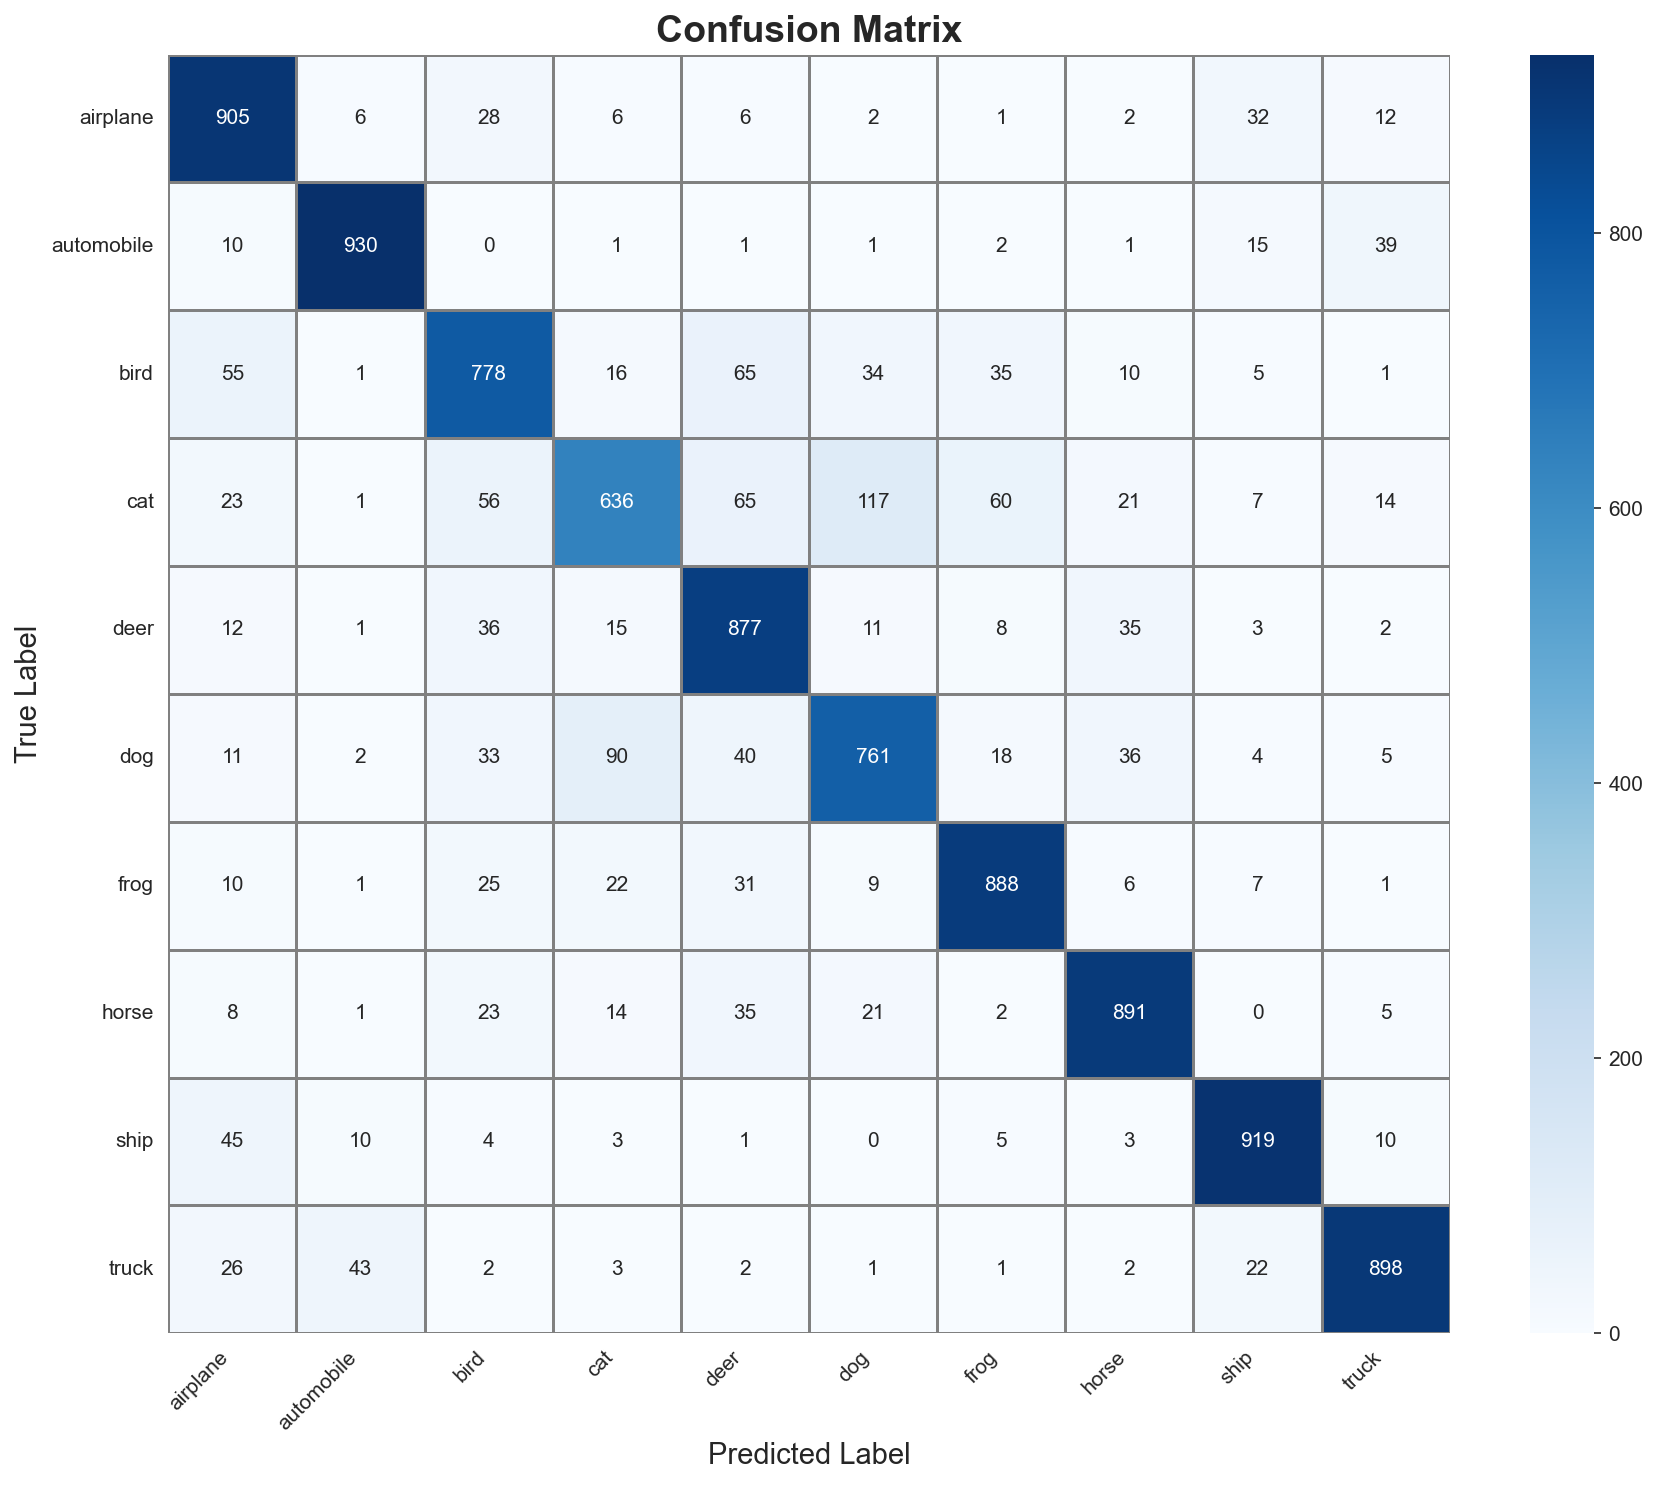

In [14]:
# Get predicted labels for the test set
y_pred_probs = model.predict(test_images)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = test_labels.flatten()

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(12, 10), dpi=150) # Larger figure, higher DPI
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, # Added color bar
            xticklabels=class_names, yticklabels=class_names, linewidths=.7, linecolor='gray', annot_kws={"size": 10}) # Sharper lines, adjusted annotation size
plt.title('Confusion Matrix', fontsize=18, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10) # Adjust font size for ticks
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


Visualizing attention maps...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


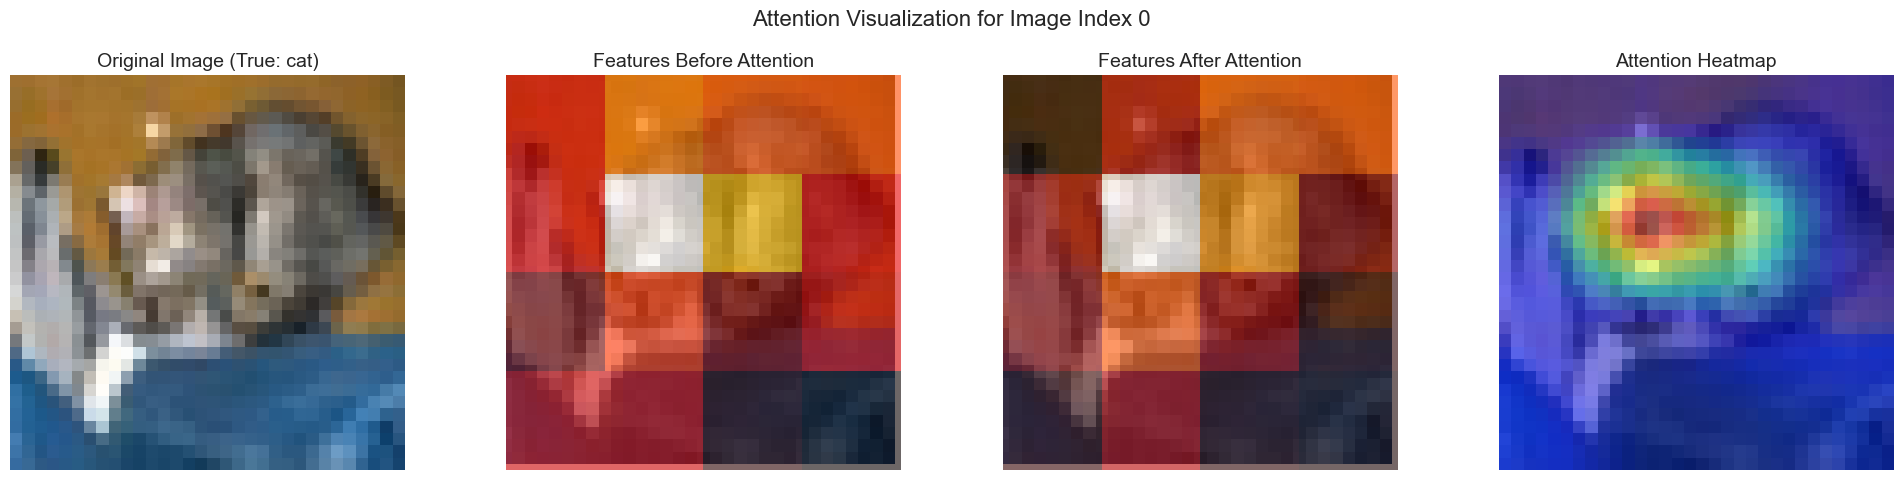

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


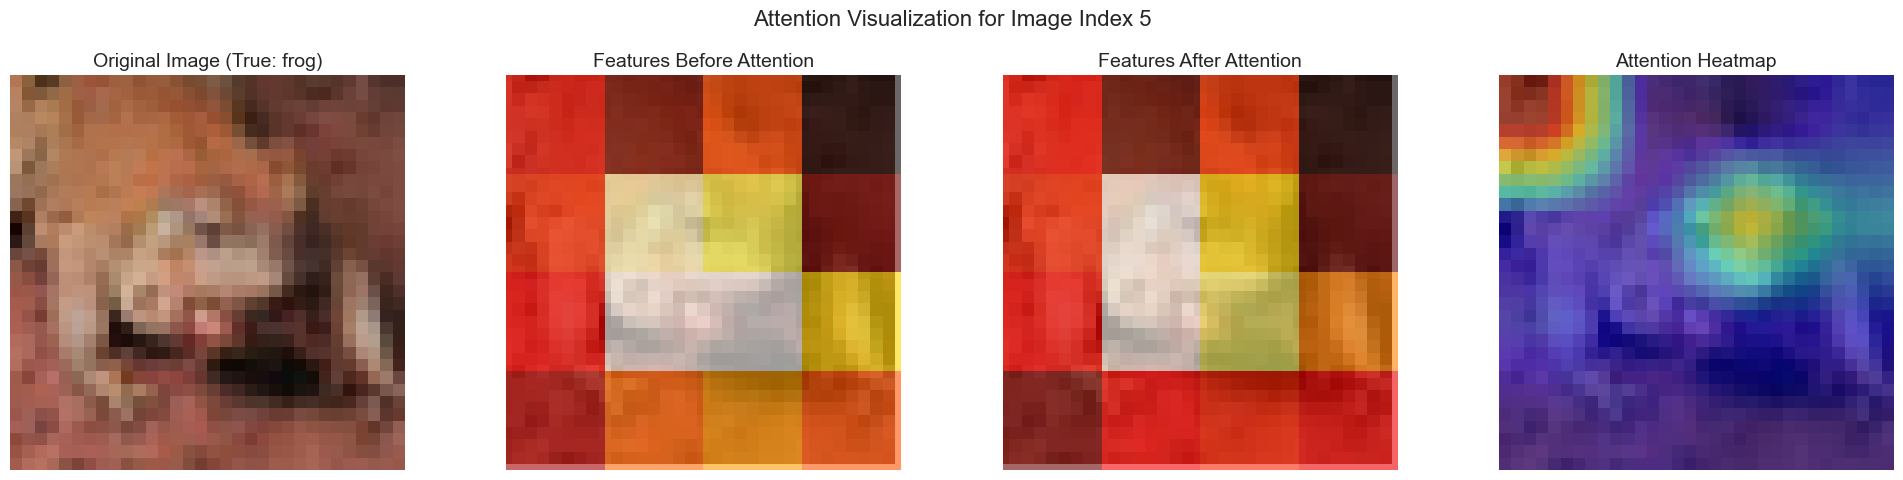

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


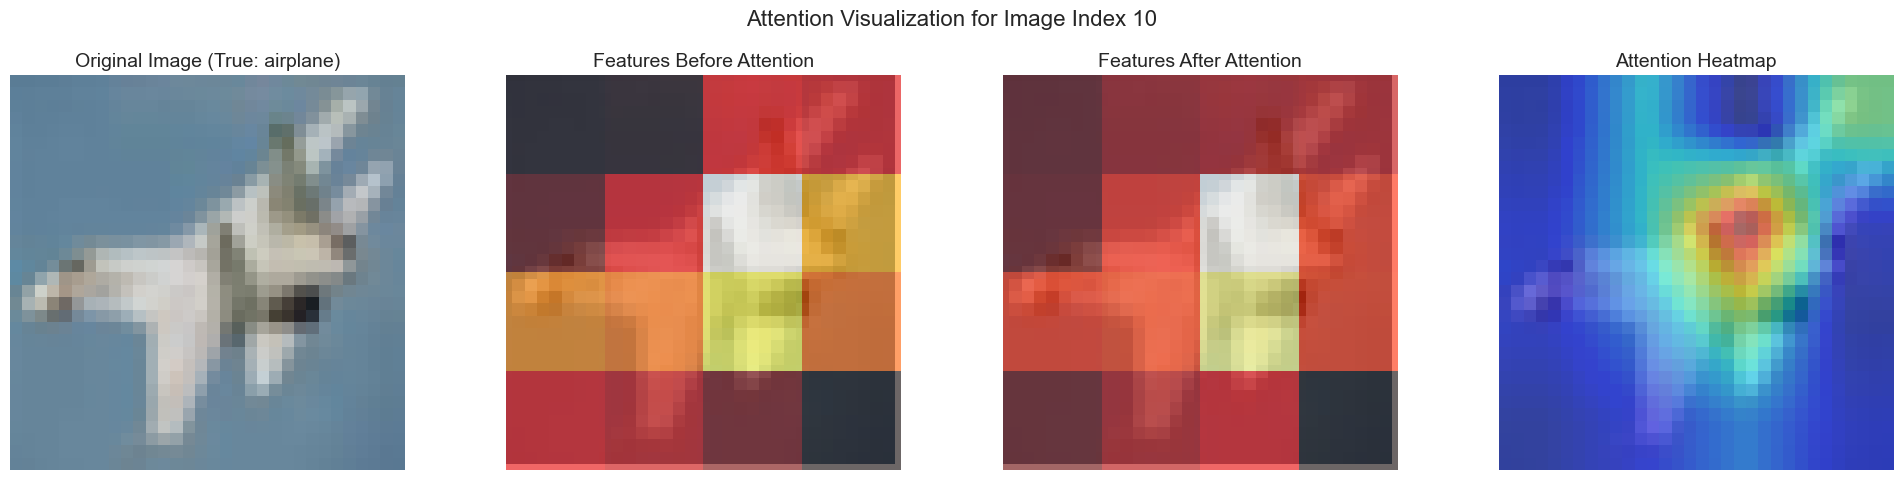

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


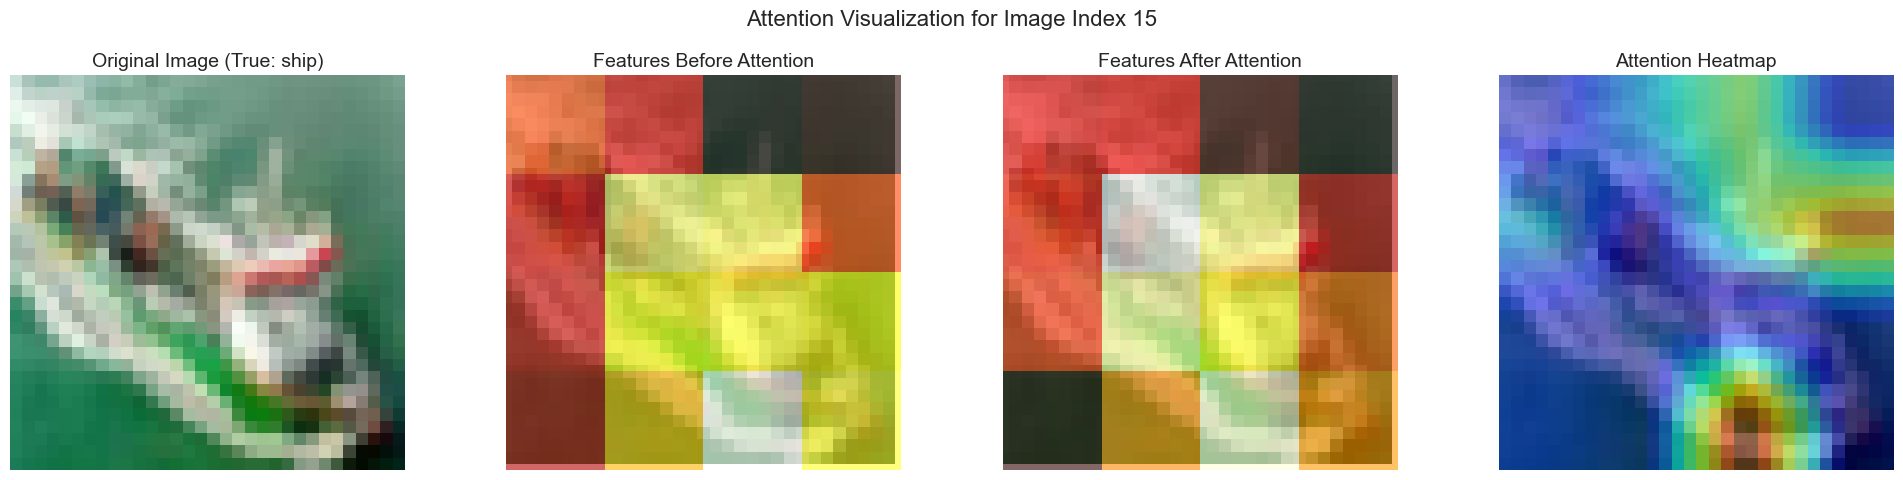

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


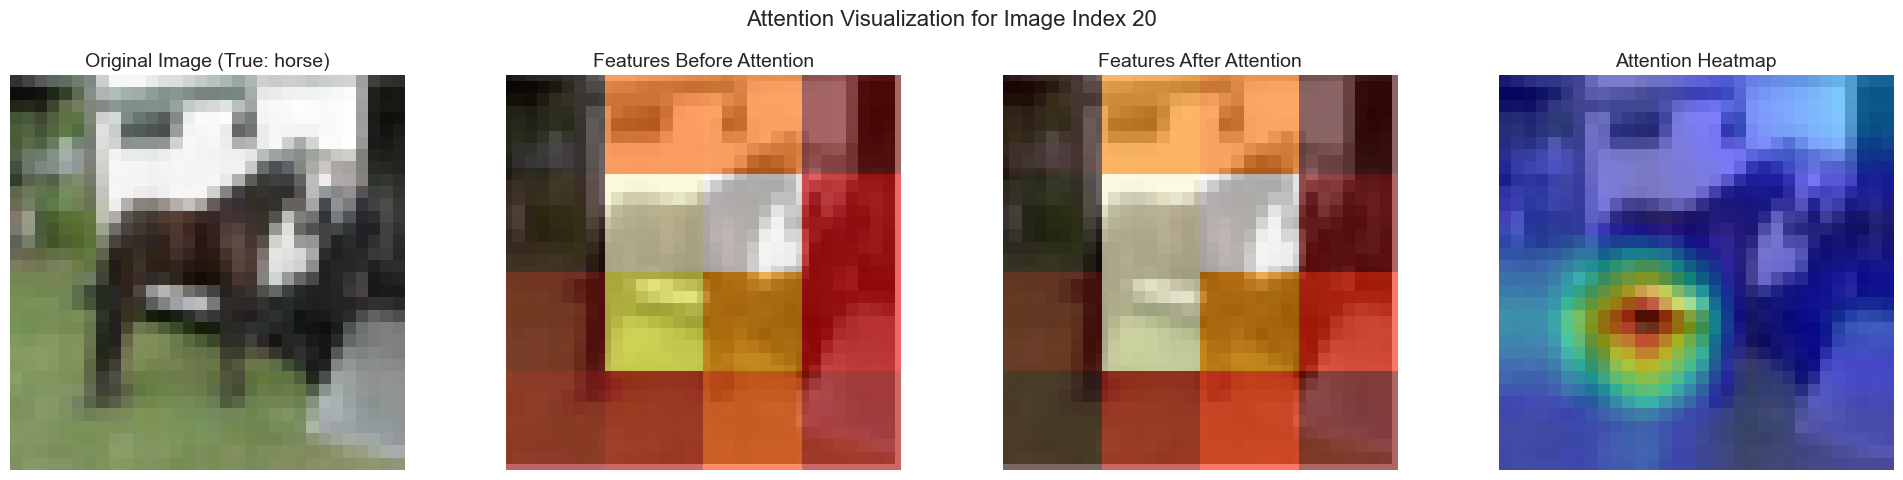

In [15]:
print("\nVisualizing attention maps...")
# Create a functional model to get outputs at specific layers

attention_model_visualizer = Model(inputs=model.input,
                                   outputs=[pre_attention_features_tensor, # Features before attention
                                            post_attention_features_tensor, # Features after attention
                                            attention_scores_tensor]) # Raw attention scores


def visualize_attention_map(image_index):
    """
    Visualizes the original image, features before/after attention, and the attention heatmap.
    """
    original_image = test_images[image_index]
    original_label = class_names[test_labels[image_index][0]]

    # Add batch dimension
    input_image = np.expand_dims(original_image, axis=0)

    # Get outputs from the visualization model
    features_before_attention, features_after_attention, attention_scores_val = \
        attention_model_visualizer.predict(input_image)

    # --- Process Features for Visualization ---
    # Average across channels for a general heatmap of activity
    avg_features_before = np.mean(features_before_attention[0], axis=-1)
    avg_features_after = np.mean(features_after_attention[0], axis=-1)

    # --- Process Attention Scores for Heatmap ---
    # attention_scores_val shape: (1, N, N) where N = h*w
    # To get a single heatmap (which position was attended to most),
    # we sum/average across the 'query' dimension (axis=0 after batch dim).
    # This gives us a (N_keys,) vector, where each element is the accumulated attention for that key position.
    attention_map_flat = np.mean(attention_scores_val[0], axis=0) # Sum or mean. Mean is generally good.

    # Get the spatial dimensions of the feature map (H', W')
    h_prime, w_prime, _ = features_before_attention.shape[1:] # e.g., 4x4

    # Reshape the attention map from (N_keys,) to (H', W')
    attention_map_2d = attention_map_flat.reshape(h_prime, w_prime)

    # Normalize the attention map for better visualization (0 to 1)
    # This ensures the heatmap colors are consistent
    attention_map_2d = (attention_map_2d - attention_map_2d.min()) / (attention_map_2d.max() - attention_map_2d.min() + 1e-8)

    # Optional: Apply a power or exponential to emphasize differences,
    # but be careful not to lose information.
    # attention_map_2d = np.power(attention_map_2d, 2) # Example to sharpen contrasts

    # --- Plotting ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5)) # Increased subplot count for attention map

    # Original Image
    axes[0].imshow(original_image)
    axes[0].set_title(f'Original Image (True: {original_label})', fontsize=14)
    axes[0].axis('off')

    # Features Before Attention (Heatmap overlaid)
    axes[1].imshow(original_image, cmap='gray') # Show original image faintly
    axes[1].imshow(avg_features_before, cmap='hot', alpha=0.6, extent=[0, original_image.shape[1], original_image.shape[0], 0]) # Overlay heatmap, use extent for alignment
    axes[1].set_title('Features Before Attention', fontsize=14)
    axes[1].axis('off')

    # Features After Attention (Heatmap overlaid)
    axes[2].imshow(original_image, cmap='gray') # Show original image faintly
    axes[2].imshow(avg_features_after, cmap='hot', alpha=0.6, extent=[0, original_image.shape[1], original_image.shape[0], 0]) # Overlay heatmap, use extent for alignment
    axes[2].set_title('Features After Attention', fontsize=14)
    axes[2].axis('off')

    # Attention Map (Overlayed Heatmap)
    axes[3].imshow(original_image) # Show original image beneath the heatmap
    # Resize the attention map to the original image dimensions for overlay
    resized_attention_map = tf.image.resize(tf.expand_dims(attention_map_2d, -1),
                                            original_image.shape[:2],
                                            method='bilinear')[...,0]
    axes[3].imshow(resized_attention_map, cmap='jet', alpha=0.5) # Overlay attention map with transparency
    axes[3].set_title('Attention Heatmap', fontsize=14)
    axes[3].axis('off')


    plt.suptitle(f'Attention Visualization for Image Index {image_index}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Choose a few test image indices to visualize
image_indices_to_visualize = [0, 5, 10, 15, 20] # Example indices

for idx in image_indices_to_visualize:
    visualize_attention_map(idx)